In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.layers import LSTM, Bidirectional
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling1D

from nltk.corpus import stopwords
from nltk import word_tokenize

from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models import FastText


In [ ]:
# embedding_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/roman_urdu_cleaned_embeddings.csv')
# print(len(embedding_data))
depression_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/roman_urdu_all_data.csv')
print(len(depression_data))
# embedding_data = embedding_data.append(depression_data, ignore_index=True)
# embedding_data = embedding_data.astype(str)

9526


In [ ]:
# df_temp = embedding_data.sample(frac = .05)
# df_temp = embedding_data

In [ ]:
# len(df_temp['text'].values)

511269

In [ ]:
# sentence_list = df_temp['text'].apply(lambda x: x.split())

# Word2Vec

In [ ]:
w2vec = Word2Vec(sentences=sentence_list.tolist(), size=100, window=3, min_count=1, workers=4)

In [ ]:
word_vectors = w2vec.wv
word_vectors.save("/content/drive/My Drive/Colab Notebooks/word2vec.wordvectors")

# FastText

In [ ]:
fText = FastText(sentence_list.tolist(), min_count=1)

In [ ]:
word_vectors = fText.wv
word_vectors.save("/content/drive/My Drive/Colab Notebooks/fText.wordvectors")

In [ ]:
wv = KeyedVectors.load("/content/drive/My Drive/Colab Notebooks/word2vec.wordvectors", mmap='r')

In [ ]:
wv.most_similar('nafrat', topn=10)

[('dalali', 0.8341929912567139),
 ('gulami', 0.8176286816596985),
 ('burai', 0.813312828540802),
 ('rajneeti', 0.8071902990341187),
 ('adat', 0.806075394153595),
 ('dushmani', 0.8018604516983032),
 ('giri', 0.7974490523338318),
 ('kamai', 0.7870802879333496),
 ('mohabbat', 0.7855555415153503),
 ('gandagi', 0.7821147441864014)]

# Creating a embedding matrix

In [ ]:
wv = KeyedVectors.load("/content/drive/My Drive/Colab Notebooks/fText.wordvectors", mmap='r')

In [ ]:
depression_data = depression_data.astype(str)

In [ ]:
x = np.array(depression_data['text'])
y = np.array(depression_data['Label'])
y = y.astype(float)
y = y.astype(int)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(depression_data['text'].values)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen=280)
X_test = sequence.pad_sequences(X_test, maxlen=280)

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  if word in wv.vocab:
    embedding_vector = wv[word]
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [ ]:
batch_size = 32
epochs = 10

# CNN


In [ ]:
model = Sequential() 
# model.add(Embedding(vocab_size, 100, input_length=280))
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=280, trainable=False))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 100)          2993600   
                                                                 
 conv1d (Conv1D)             (None, 280, 128)          51328     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 140, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 140, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 70, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 70, 32)            8

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), verbose=2)
# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
200/200 - 33s - loss: 0.2445 - accuracy: 0.8808 - val_loss: 0.2281 - val_accuracy: 0.8890 - 33s/epoch - 166ms/step
Epoch 2/10
200/200 - 31s - loss: 0.1939 - accuracy: 0.9099 - val_loss: 0.2156 - val_accuracy: 0.8919 - 31s/epoch - 155ms/step
Epoch 3/10
200/200 - 22s - loss: 0.1598 - accuracy: 0.9284 - val_loss: 0.2443 - val_accuracy: 0.8877 - 22s/epoch - 111ms/step
Epoch 4/10
200/200 - 20s - loss: 0.1464 - accuracy: 0.9322 - val_loss: 0.2502 - val_accuracy: 0.8810 - 20s/epoch - 102ms/step
Epoch 5/10
200/200 - 20s - loss: 0.1015 - accuracy: 0.9600 - val_loss: 0.2877 - val_accuracy: 0.8896 - 20s/epoch - 102ms/step
Epoch 6/10
200/200 - 20s - loss: 0.0876 - accuracy: 0.9646 - val_loss: 0.2742 - val_accuracy: 0.8906 - 20s/epoch - 102ms/step
Epoch 7/10
200/200 - 21s - loss: 0.0807 - accuracy: 0.9702 - val_loss: 0.2869 - val_accuracy: 0.8912 - 21s/epoch - 105ms/step
Epoch 8/10
200/200 - 24s - loss: 0.0471 - accuracy: 0.9821 - val_loss: 0.4280 - val_accuracy: 0.8899 - 24s/epoch - 122

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/ft-CNN')

In [ ]:
CNN_test_pridict = model.predict(X_test) 
arr = []
for i in range(len(CNN_test_pridict)):
  if CNN_test_pridict[i]>=0.5:
    arr.append(1)
  else:
    arr.append(0)
print(len(arr))
print(len(y_test))

3144
3144


In [ ]:
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test,arr)
print ("fbeta_score on Testing Data is:", fbeta_score)
print('precision: ', precision)
print('recall: ', recall)

fbeta_score on Testing Data is: [0.9324821  0.68811439]
precision:  [0.92656671 0.70902394]
recall:  [0.93847352 0.66840278]


[Text(33.0, 0.5, 'True Labels'), Text(0.5, 15.0, 'Predicted Labels')]

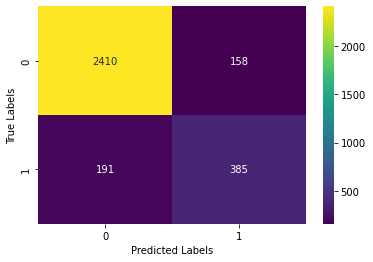

In [ ]:
import seaborn as sns
cf_matrix = confusion_matrix(y_test,arr)
s = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="viridis")
s.set(xlabel='Predicted Labels', ylabel='True Labels')

# LSTM

In [ ]:
model = Sequential() 
# model.add(Embedding(vocab_size, 100, input_length=280))
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=280, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 100)          2993600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,110,977
Trainable params: 117,377
Non-trainable params: 2,993,600
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=2)
# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
200/200 - 159s - loss: 0.3540 - precision: 0.6163 - recall: 0.3998 - val_loss: 0.2499 - val_precision: 0.6767 - val_recall: 0.5486 - 159s/epoch - 794ms/step
Epoch 2/10
200/200 - 154s - loss: 0.2496 - precision: 0.6585 - recall: 0.6645 - val_loss: 0.2254 - val_precision: 0.6693 - val_recall: 0.7309 - 154s/epoch - 772ms/step
Epoch 3/10
200/200 - 153s - loss: 0.2171 - precision: 0.6834 - recall: 0.7403 - val_loss: 0.2244 - val_precision: 0.6125 - val_recall: 0.9219 - 153s/epoch - 767ms/step
Epoch 4/10
200/200 - 154s - loss: 0.1932 - precision: 0.7215 - recall: 0.8137 - val_loss: 0.2066 - val_precision: 0.7060 - val_recall: 0.7170 - 154s/epoch - 769ms/step
Epoch 5/10
200/200 - 152s - loss: 0.2057 - precision: 0.7176 - recall: 0.7815 - val_loss: 0.2028 - val_precision: 0.6685 - val_recall: 0.8264 - 152s/epoch - 759ms/step
Epoch 6/10
200/200 - 153s - loss: 0.1745 - precision: 0.7530 - recall: 0.8244 - val_loss: 0.2068 - val_precision: 0.6516 - val_recall: 0.9028 - 153s/epoch - 767

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/ft-LSTM')

In [ ]:
CNN_test_pridict = model.predict(X_test) 
arr = []
for i in range(len(CNN_test_pridict)):
  if CNN_test_pridict[i]>=0.5:
    arr.append(1)
  else:
    arr.append(0)
print(len(arr))
print(len(y_test))

3144
3144


In [ ]:
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test,arr)
print ("fbeta_score on Testing Data is:", fbeta_score)
print('precision: ', precision)
print('recall: ', recall)

fbeta_score on Testing Data is: [0.94246032 0.76762821]
precision:  [0.96076052 0.71279762]
recall:  [0.92484424 0.83159722]


[Text(33.0, 0.5, 'True Labels'), Text(0.5, 15.0, 'Predicted Labels')]

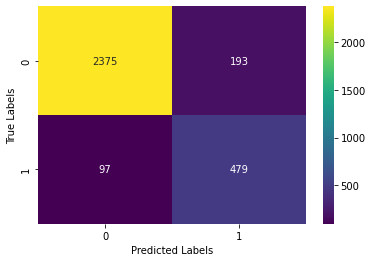

In [ ]:
cf_matrix = confusion_matrix(y_test,arr)
s = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="viridis")
s.set(xlabel='Predicted Labels', ylabel='True Labels')

# Bi-LSTM

In [ ]:
model = Sequential() 
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=280, trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 280, 100)          2993600   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,228,353
Trainable params: 234,753
Non-trainable params: 2,993,600
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=2)
# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
200/200 - 307s - loss: 0.3542 - precision_1: 0.6088 - recall_1: 0.3669 - val_loss: 0.2531 - val_precision_1: 0.6164 - val_recall_1: 0.7951 - 307s/epoch - 2s/step
Epoch 2/10
200/200 - 300s - loss: 0.2489 - precision_1: 0.6524 - recall_1: 0.6933 - val_loss: 0.2217 - val_precision_1: 0.6560 - val_recall_1: 0.7812 - 300s/epoch - 2s/step
Epoch 3/10
200/200 - 298s - loss: 0.2125 - precision_1: 0.6865 - recall_1: 0.7799 - val_loss: 0.2124 - val_precision_1: 0.6469 - val_recall_1: 0.8333 - 298s/epoch - 1s/step
Epoch 4/10
200/200 - 302s - loss: 0.1951 - precision_1: 0.7067 - recall_1: 0.8145 - val_loss: 0.2121 - val_precision_1: 0.6592 - val_recall_1: 0.8628 - 302s/epoch - 2s/step
Epoch 5/10
200/200 - 303s - loss: 0.1905 - precision_1: 0.7257 - recall_1: 0.8112 - val_loss: 0.2095 - val_precision_1: 0.6345 - val_recall_1: 0.8681 - 303s/epoch - 2s/step
Epoch 6/10
200/200 - 308s - loss: 0.1786 - precision_1: 0.7453 - recall_1: 0.8203 - val_loss: 0.2111 - val_precision_1: 0.6434 - val_re

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/ft-BILSTM')

In [ ]:
CNN_test_pridict = model.predict(X_test) 
arr = []
for i in range(len(CNN_test_pridict)):
  if CNN_test_pridict[i]>=0.5:
    arr.append(1)
  else:
    arr.append(0)
print(len(arr))
print(len(y_test))

3144
3144


In [ ]:
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test,arr)
print ("fbeta_score on Testing Data is:", fbeta_score)
print('precision: ', precision)
print('recall: ', recall)

fbeta_score on Testing Data is: [0.94008672 0.74958814]
precision:  [0.95171588 0.71316614]
recall:  [0.92873832 0.78993056]


[Text(33.0, 0.5, 'True Labels'), Text(0.5, 15.0, 'Predicted Labels')]

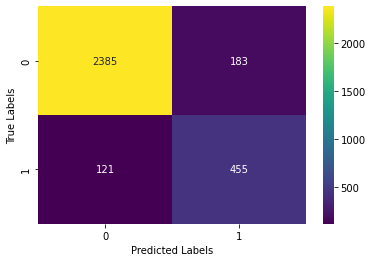

In [ ]:
cf_matrix = confusion_matrix(y_test,arr)
s = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="viridis")
s.set(xlabel='Predicted Labels', ylabel='True Labels')